# AI 201 Programming Assignment 4
## Boosted Perceptron vs. SVM

Submitted by: 
Jan Lendl R. Uy, 2019-00312

## Install and import necessary libraries
- numpy
- scikit-learn
- matplotlib

In [1]:
!pip install numpy scikit-learn matplotlib

In [81]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [3]:
BANANA_DATASET = "banana_data.csv"
SPLICE_DATASET = "splice_data.csv"

## Read the banana and splice datasets

In [4]:
def read_dataset(filepath):
    # Load the entire dataset using numpy
    data = np.loadtxt(filepath, delimiter=",")
    
    # Separate features and labels
    y = data[:, 0]  # First column contains the labels
    X = data[:, 1:]  # Succeeding columns contain the features
    
    return X, y

In [5]:
X_banana, y_banana = read_dataset(BANANA_DATASET)
X_splice, y_splice = read_dataset(SPLICE_DATASET)

print(f"X_banana: {X_banana.shape}")
print(f"y_banana: {y_banana.shape}")
print(f"X_splice: {X_splice.shape}")
print(f"y_splice: {y_splice.shape}")

X_banana: (5300, 2)
y_banana: (5300,)
X_splice: (2991, 60)
y_splice: (2991,)


## Split the datasets into training and test sets
- Banana dataset
    - Training: 400 samples
    - Test: 4900 samples
- Splice dataset:
    - Training: 1000 samples
    - Test: 2175 samples

In [6]:
def train_test_split(X, y, test_size=0.3, random_state=None):
    if random_state is not None:
        random.seed(random_state)
    
    # Create list of indices and shuffle it
    indices = list(range(len(X)))
    random.shuffle(indices)
    
    # Calculate split point
    split = int(len(X) * (1 - test_size))
    
    # Split the data
    train_indices = indices[:split]
    test_indices = indices[split:]
    
    X_train = np.array([X[i] for i in train_indices])
    X_test = np.array([X[i] for i in test_indices])
    y_train = np.array([y[i] for i in train_indices])
    y_test = np.array([y[i] for i in test_indices])
    
    return X_train, X_test, y_train, y_test

In [7]:
X_banana_train, X_banana_test, y_banana_train, y_banana_test = train_test_split(X_banana, 
                                                                                y_banana, 
                                                                                test_size=(4900-1)/X_banana.shape[0], 
                                                                                random_state=0)

print(f"X_banana_train: {X_banana_train.shape}")
print(f"X_banana_test: {X_banana_test.shape}")
print(f"y_banana_train: {y_banana_train.shape}")
print(f"y_banana_test: {y_banana_test.shape}")

X_banana_train: (400, 2)
X_banana_test: (4900, 2)
y_banana_train: (400,)
y_banana_test: (4900,)


In [8]:
X_splice_train, X_splice_test, y_splice_train, y_splice_test = train_test_split(X_splice,
                                                                                y_splice, 
                                                                                test_size=2175/X_splice.shape[0], 
                                                                                random_state=0)

print(f"X_splice_train: {X_splice_train.shape}")
print(f"X_splice_test: {X_splice_test.shape}")
print(f"y_splice_train: {y_splice_train.shape}")
print(f"y_splice_test: {y_splice_test.shape}")

X_splice_train: (816, 60)
X_splice_test: (2175, 60)
y_splice_train: (816,)
y_splice_test: (2175,)


## Perfomance Metric: Accuracy
Accuracy will be used to evaluate the performance of the Boosted Perceptron and Support Vector Machine on the banana and splice datasets

In [9]:
def accuracy_score(y_true, y_pred):    
    # Calculate accuracy
    return np.mean(y_true == y_pred)

## Perceptron Classifier
The Perceptron Classifier was implemented from scratch using only numpy. It has the following methods:
- classify()
    - Trains the Perceptron Classifier using the Pocket Algorithm with the maximum iteration count set to 10,000 by default
- predict()
    - Perform inferences on a test set for the evaluation of model performance
    - Outputs the predictions of the trained Perceptron Classifier

In [ ]:
class PerceptronClassifier:
    
    def __init__(self):
        """Initialize the Perceptron Classifier"""
        self.w = None  # weight vector (including bias)
        self.d = None  # number of features
        
    def classify(self, X, y, max_iter_cnt=10000, random_state=0):
        """Train the perceptron using the Pocket Algorithm"""
        # Add bias to X
        N, self.d = X.shape
        X_with_bias = np.hstack((np.ones((N, 1)), X))  # Add column of 1s for bias
        
        # Initialize variables as per pocket algorithm
        v = np.zeros(self.d + 1)  # Current weight vector
        w = np.zeros(self.d + 1)  # pocket weight vector
        n_v = 0  # Consecutive correct classifications for v
        n_w = 0  # Consecutive correct classifications for w
        iter_cnt = 0
        
        while iter_cnt < max_iter_cnt:
            # Randomly choose an input pattern
            j = np.random.randint(0, N)
            x_j = X_with_bias[j]
            y_j = y[j]
            
            # Compute neuron's output
            y_pred = 1 if np.dot(v, x_j) >= 0 else -1
            
            # Check if correctly classified
            if y_pred == y_j:
                n_v += 1
                # Update pocket weights if current weights are better
                if n_v > n_w:
                    w = v.copy()
                    n_w = n_v
            else:
                # Update weights if misclassified
                v = v + y_j * x_j
                n_v = 0
            
            iter_cnt += 1
        
        # Store the best weights found
        self.w = w
    
    def predict(self, X):
        """Predict labels for test data"""
        if self.w is None:
            raise ValueError("Model not trained yet. Call classify() first.")
        
        # Add bias to X
        X_with_bias = np.hstack((np.ones((X.shape[0], 1)), X))
        
        # Compute predictions
        y_pred = np.where(np.dot(X_with_bias, self.w) >= 0, 1, -1)
        
        return y_pred
    
    def compute_error(self, y_true, y_pred):
        """Compute sum of squared errors"""
        return np.sum((y_true - y_pred) ** 2)

### Create synthetic training and test sets for the Perceptron Classifier
These synthetic datasets will be used to validate that the implementation works as intended

In [11]:
def generate_classification_data():
    # Generate 100 points for class -1 from N([0,0], I)
    class_neg = np.random.multivariate_normal(
        mean=[0, 0],
        cov=np.eye(2),
        size=100
    )
    
    # Generate 100 points for class +1 from N([10,10], I)
    class_pos = np.random.multivariate_normal(
        mean=[10, 10],
        cov=np.eye(2),
        size=100
    )
    
    # Split each class into training (50) and test (50) sets
    X_train = np.vstack((class_neg[:50], class_pos[:50]))
    X_test = np.vstack((class_neg[50:], class_pos[50:]))
    
    # Create corresponding labels
    y_train = np.array([-1]*50 + [1]*50)
    y_test = np.array([-1]*50 + [1]*50)
    
    return X_train, X_test, y_train, y_test

### Train and evalaute the Perceptron Classifier on the synthetic dataset
Sum of squared errors must approach zero to indicate that training implementation (i.e. Pocket Algorithm) is correct

In [12]:
X_synthetic_train, X_synthetic_test, y_synthetic_train, y_synthetic_test = generate_classification_data()
perceptron = PerceptronClassifier()
perceptron.classify(X_synthetic_train, y_synthetic_train)
y_synthetic_pred = perceptron.predict(X_synthetic_test)
print(f"Sum of Squared Errors of the Perceptron Classifier on Synthetic Test Set: {perceptron.compute_error(y_synthetic_pred, y_synthetic_test)}")

Sum of Squared Errors of the Perceptron Classifier on Synthetic Test Set: 0


## Adaboost
AdaBoost is the underlying algorithm used for building a strong classifier out of an ensemble of Perceptron Classifiers (i.e. weak learners). The following methods are implemented to perform training and inference:
- adabtrain()
- adabpredict()

In [ ]:
class AdaBoost:
    def __init__(self, k=10):
        """Initialize AdaBoost with K weak learners"""
        self.k = k  # Number of weak learners
        self.alphas = []  # Coefficients for each weak learner
        self.weak_learners = []  # List of trained perceptrons
    
    def adabtrain(self, X, y):
        """Train AdaBoost using Perceptron as weak learner"""
        N = X.shape[0]
        # Initialize weights uniformly
        w = np.ones(N) / N
        
        self.alphas = []
        self.weak_learners = []
        
        for t in range(self.k):
            # 1. Sample training set with replacement according to weights
            indices = np.random.choice(N, size=N, p=w)
            X_sampled = X[indices]
            y_sampled = y[indices]
            
            # 2. Train weak learner
            weak_learner = PerceptronClassifier()
            weak_learner.classify(X_sampled, y_sampled)
            
            # 3. Compute weighted error on original dataset
            h = weak_learner.predict(X)
            incorrect = (h != y)
            epsilon = np.sum(w * incorrect)
            
            # Check if weak learner is better than random
            if epsilon > 0.5:
                continue  # Skip this iteration if weak learner is worse than random
                
            # 4. Compute coefficient alpha
            alpha = 0.5 * np.log((1 - epsilon) / (epsilon))
            
            # 5. Update weights
            w = w * np.exp(-alpha * y * h)
            
            # Normalize weights
            w = w / np.sum(w)
            
            # Store weak learner and its coefficient
            self.weak_learners.append(weak_learner)
            self.alphas.append(alpha)
        
        return self.alphas, self.weak_learners
    
    def adabpredict(self, X):
        """Make predictions using trained ensemble"""
        if not self.weak_learners:
            raise ValueError("Model not trained yet. Call adabtrain() first.")
        
        # Get predictions from all weak learners
        N = X.shape[0]
        weighted_predictions = np.zeros(N)
        
        # Combine weak learners using their coefficients
        for alpha, learner in zip(self.alphas, self.weak_learners):
            predictions = learner.predict(X)
            weighted_predictions += alpha * predictions
        
        # Return final predictions
        return np.sign(weighted_predictions)

## Construct the Boosted Perceptron
Build Perceptron Classifiers for an initial evaluation of the ensemble model on the two datasets

### Train and evaluate the Boosted Perceptron on the Banana Dataset

In [95]:
boosted_perceptron = AdaBoost(k=900)

start_time = time.time()
boosted_perceptron.adabtrain(X_banana_train, y_banana_train)
bp_banana_training_time = time.time() - start_time

start_time = time.time()
y_banana_pred = boosted_perceptron.adabpredict(X_banana_test)
bp_banana_testing_time = time.time() - start_time

bp_banana_accuracy = accuracy_score(y_banana_pred, y_banana_test)

print(f"Boosted Perceptron Accuracy on Banana Dataset: {bp_banana_accuracy:.5f}")
print(f"Boosted Perceptron Training Time: {bp_banana_training_time:.5f} s")
print(f"Boosted Perceptron Testing Time: {bp_banana_testing_time:.5f} s")

Boosted Perceptron Accuracy on Banana Dataset: 0.87592
Boosted Perceptron Training Time: 17.56360 s
Boosted Perceptron Testing Time: 0.03343 s


### Train and evaluate the Boosted Perceptron on the Splice Dataset

In [96]:
boosted_perceptron = AdaBoost(k=1000)

start_time = time.time()
boosted_perceptron.adabtrain(X_splice_train, y_splice_train)
bp_splice_training_time = time.time() - start_time

start_time = time.time()
y_splice_pred = boosted_perceptron.adabpredict(X_splice_test)
bp_splice_testing_time = time.time() - start_time

bp_splice_accuracy = accuracy_score(y_splice_pred, y_splice_test)

print(f"Boosted Perceptron Accuracy on Splice Dataset: {bp_splice_accuracy:.5f}")
print(f"Boosted Perceptron Training Time: {bp_splice_training_time:.5f} s")
print(f"Boosted Perceptron Testing Time: {bp_splice_testing_time:.5f} s")

Boosted Perceptron Accuracy on Splice Dataset: 0.83494
Boosted Perceptron Training Time: 19.58392 s
Boosted Perceptron Testing Time: 0.06693 s


### Get the performance of the Boosted Perceptron for varying $k$

In [ ]:
def evaluate_boosted_perceptron_varying_k(k_values, X_train, y_train, X_test, y_test):
    train_accuracies = []
    test_accuracies = []
    train_times = []
    test_times = []

    for k in k_values:
        print(f"Training AdaBoost with k={k}")
        
        # Initialize and train model
        boosted_perceptron = AdaBoost(k=k)
        
        # Training time
        start_time = time.time()
        boosted_perceptron.adabtrain(X_train, y_train)
        train_time = time.time() - start_time
        y_train_pred = boosted_perceptron.adabpredict(X_train)
        # train_times.append(train_time)
        
        # Testing time
        start_time = time.time()
        y_test_pred = boosted_perceptron.adabpredict(X_test)
        test_time = time.time() - start_time
        # test_times.append(test_time)
        
        # Calculate accuracies
        train_acc = accuracy_score(y_train_pred, y_train)
        test_acc = accuracy_score(y_test_pred, y_test)
        
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
                
    return train_accuracies, test_accuracies

In [72]:
def plot_results(k_values, train_accuracies, test_accuracies, title):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))    
    
    # Plot training accuracy
    ax1.plot(k_values, train_accuracies, 'b-', linewidth=2)
    ax1.set_xlabel('Number of Weak Learners (K)')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training Accuracy vs Number of Weak Learners')
    ax1.grid(True)
    ax1.set_ylim([min(train_accuracies)-0.05, max(train_accuracies)+0.05])
    
    # Plot testing accuracy
    ax2.plot(k_values, test_accuracies, 'r-', linewidth=2)
    ax2.set_xlabel('Number of Weak Learners (K)')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Testing Accuracy vs Number of Weak Learners')
    ax2.grid(True)
    ax2.set_ylim([min(test_accuracies)-0.05, max(test_accuracies)+0.05])
        
    fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()

In [73]:
k_values = [i for i in range(10, 100, 10)] + [i for i in range(100, 1100, 100)]

Training AdaBoost with k=10
Training AdaBoost with k=20
Training AdaBoost with k=30
Training AdaBoost with k=40
Training AdaBoost with k=50
Training AdaBoost with k=60
Training AdaBoost with k=70
Training AdaBoost with k=80
Training AdaBoost with k=90
Training AdaBoost with k=100
Training AdaBoost with k=200
Training AdaBoost with k=300
Training AdaBoost with k=400
Training AdaBoost with k=500
Training AdaBoost with k=600
Training AdaBoost with k=700
Training AdaBoost with k=800
Training AdaBoost with k=900
Training AdaBoost with k=1000


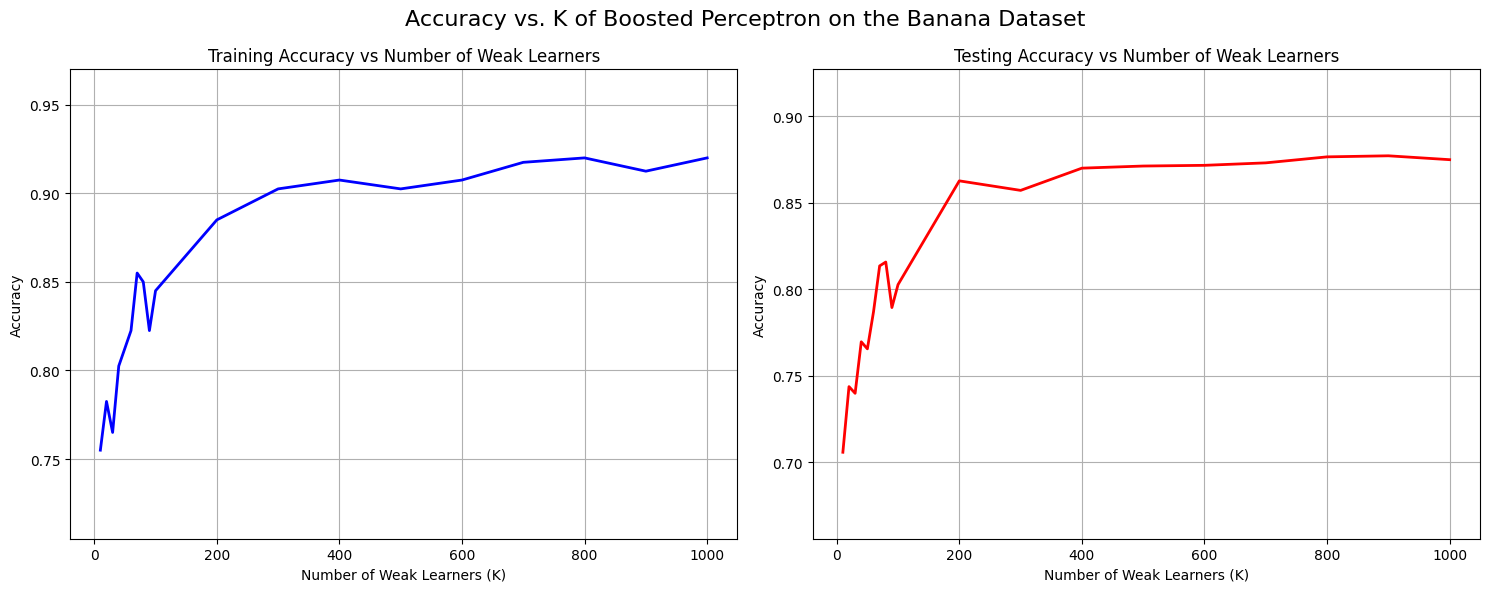

In [74]:
banana_train_accuracies, banana_test_accuracies = evaluate_boosted_perceptron_varying_k(k_values, 
                                                                X_banana_train, 
                                                                y_banana_train, 
                                                                X_banana_test, 
                                                                y_banana_test)

fig = plot_results(k_values, banana_train_accuracies, banana_test_accuracies, "Accuracy vs. K of Boosted Perceptron on the Banana Dataset")

Training AdaBoost with k=10
Training AdaBoost with k=20
Training AdaBoost with k=30
Training AdaBoost with k=40
Training AdaBoost with k=50
Training AdaBoost with k=60
Training AdaBoost with k=70
Training AdaBoost with k=80
Training AdaBoost with k=90
Training AdaBoost with k=100
Training AdaBoost with k=200
Training AdaBoost with k=300
Training AdaBoost with k=400
Training AdaBoost with k=500
Training AdaBoost with k=600
Training AdaBoost with k=700
Training AdaBoost with k=800
Training AdaBoost with k=900
Training AdaBoost with k=1000


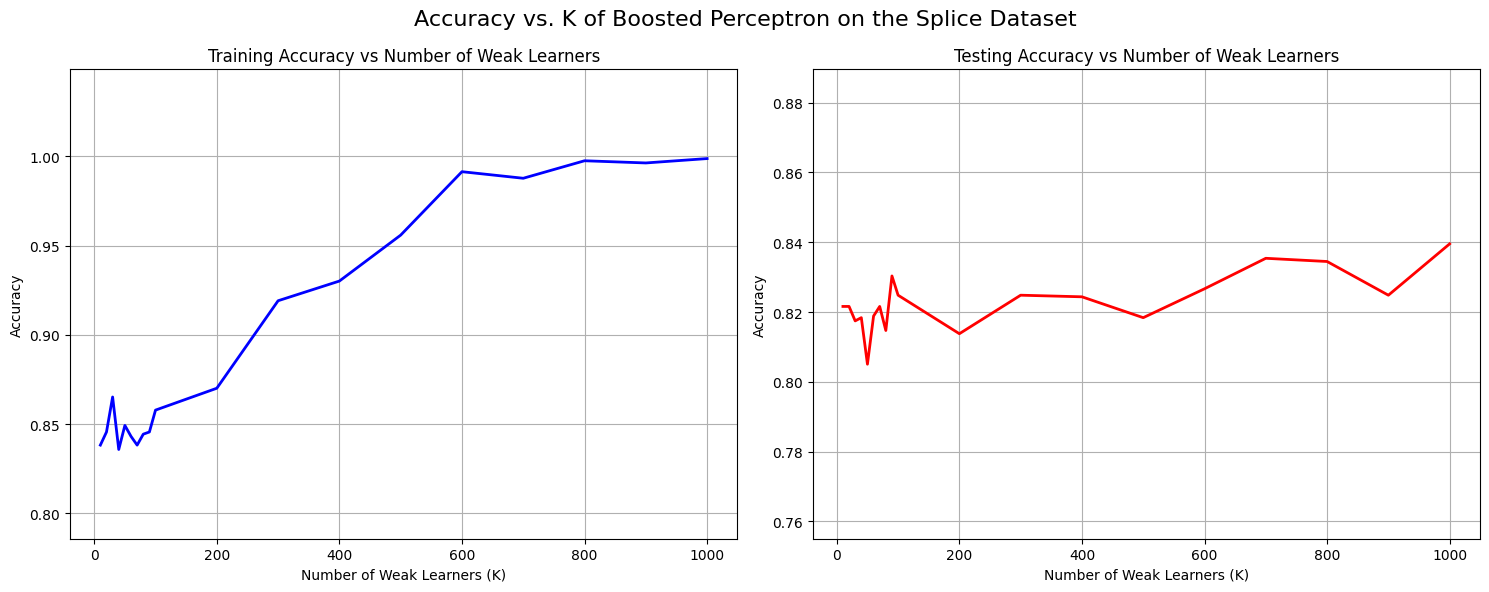

In [75]:
splice_train_accuracies, splice_test_accuracies = evaluate_boosted_perceptron_varying_k(k_values, 
                                                                X_splice_train, 
                                                                y_splice_train, 
                                                                X_splice_test, 
                                                                y_splice_test)

plot_results(k_values, splice_train_accuracies, splice_test_accuracies, "Accuracy vs. K of Boosted Perceptron on the Splice Dataset")

### Obtaining the best Boosted Perceptron Model

In [21]:
best_perf_banana_dataset = max(banana_test_accuracies)
best_k_banana_dataset = k_values[banana_test_accuracies.index(best_perf_banana_dataset)]
print(f"Boosted Perceptron Best Accuracy for Banana Dataset: {best_perf_banana_dataset}")
print(f"Boosted Perceptron Best K for Banana Dataset: {best_k_banana_dataset}")

best_perf_splice_dataset = max(splice_test_accuracies)
best_k_splice_dataset = k_values[splice_test_accuracies.index(best_perf_splice_dataset)]
print(f"Boosted Perceptron Best Accuracy for Splice Dataset: {best_perf_splice_dataset}")
print(f"Boosted Perceptron Best K for Splice Dataset: {best_k_splice_dataset}")

Boosted Perceptron Best Accuracy for Banana Dataset: 0.8814285714285715
Boosted Perceptron Best K for Banana Dataset: 900
Boosted Perceptron Best Accuracy for Splice Dataset: 0.8340229885057471
Boosted Perceptron Best K for Splice Dataset: 1000


## SVM

### Initialize the parameter distribution to be tested during hyperparameter tuning
Random search will be performed to find the best set of parameters of SVM on the two datasets

In [90]:
param_distributions = {
   "C": [1e-3, 1e-2, 1e-1, 1, 2, 5],
   "kernel": ["linear", "rbf", "sigmoid"],
   "gamma": ["scale", "auto", 1e-2, 1e-1, 1]
}

### Train and evaluate the Support Vector Classifier on the Banana Dataset

In [91]:
# Initialize an SVM for classification then train
svc_banana = SVC()

start_time = time.time()
svc_banana.fit(X_banana_train, y_banana_train)
svc_banana_training_time = time.time() - start_time

# Report the accuracy, training and test speeds of the 
# trained SVC on the banana dataset
start_time = time.time()
y_banana_pred = svc_banana.predict(X_banana_test)
svc_banana_testing_time = time.time() - start_time

svc_banana_accuracy = accuracy_score(y_banana_pred, y_banana_test)

print(f"SVM Accuracy on Banana Dataset: {svc_banana_accuracy:.5f}")
print(f"SVM Training Time: {svc_banana_training_time:.5f} s")
print(f"SVM Testing Time: {svc_banana_testing_time:.5f} s")

SVM Accuracy on Banana Dataset: 0.88000
SVM Training Time: 0.00537 s
SVM Testing Time: 0.04916 s


### Tune the Support Vector Classifier on the Banana Dataset using Random Search

In [92]:
svc_banana = SVC()
grid_search_banana = GridSearchCV(
   svc_banana, param_distributions,
   n_jobs=-1, verbose=2
)

grid_search_banana.fit(X_banana_train, y_banana_train)

svc_banana_best_params = grid_search_banana.best_params_
print("Best SVM parameters for banana dataset:", svc_banana_best_params)
svc_banana_best = SVC(C=svc_banana_best_params["C"],
                      kernel=svc_banana_best_params["kernel"],
                      gamma=svc_banana_best_params["gamma"]
                      )
start_time = time.time()
svc_banana_best.fit(X_banana_train, y_banana_train)
svc_banana_training_time = time.time() - start_time

# Test evaluation
start_time = time.time()
y_banana_pred = svc_banana_best.predict(X_banana_test)
svc_banana_testing_time = time.time() - start_time

svc_banana_accuracy = accuracy_score(y_banana_pred, y_banana_test)

print(f"SVM Best Accuracy on Banana Dataset: {svc_banana_accuracy:.5f}")
print(f"SVM Training Time: {svc_banana_training_time:.5f} s")
print(f"SVM Testing Time: {svc_banana_testing_time:.5f} s")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] END ................C=0.001, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ................C=0.001, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ................C=0.001, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ................C=0.001, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ................C=0.001, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ...................C=0.001, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...............C=0.001, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ...............C=0.001, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .................C=0.001, gamma=auto, 

### Train and evaluate the Boosted Perceptron on the Splice Dataset

In [93]:
# Initialize an SVM for classification then train
svc_splice= SVC()
start_time = time.time()
svc_splice.fit(X_splice_train, y_splice_train)
svc_splice_training_time = time.time() - start_time

# Report the accuracy, training and test speeds of the 
# trained SVC on the splice dataset
start_time = time.time()
y_splice_pred = svc_splice.predict(X_splice_test)
svc_splice_testing_time = time.time() - start_time

svc_splice_accuracy = accuracy_score(y_splice_pred, y_splice_test)

print(f"SVM Accuracy on Splice Dataset: {svc_splice_accuracy:.5f}")
print(f"SVM Training Time: {svc_splice_training_time:.5f} s")
print(f"SVM Testing Time: {svc_splice_testing_time:.5f} s")

SVM Accuracy on Splice Dataset: 0.89149
SVM Training Time: 0.01476 s
SVM Testing Time: 0.10937 s


### Tune the Support Vector Classifier on the Splice Dataset using Random Search

In [94]:
svc_splice = SVC()
grid_search_splice = GridSearchCV(
   svc_splice, param_distributions,
   n_jobs=-1, verbose=2
)

grid_search_splice.fit(X_splice_train, y_splice_train)

svc_splice_best_params = grid_search_splice.best_params_
print("Best SVM parameters for splice dataset:", svc_banana_best_params)
svc_splice_best = SVC(C=svc_splice_best_params["C"],
                      kernel=svc_splice_best_params["kernel"],
                      gamma=svc_splice_best_params["gamma"]
                      )
start_time = time.time()
svc_splice_best.fit(X_splice_train, y_splice_train)
svc_splice_training_time = time.time() - start_time

start_time = time.time()
y_splice_pred = svc_splice_best.predict(X_splice_test)
svc_splice_testing_time = time.time() - start_time

svc_splice_accuracy = accuracy_score(y_splice_pred, y_splice_test)

print(f"SVM Best Accuracy on Splice Dataset: {svc_splice_accuracy:.5f}") 
print(f"SVM Training Time: {svc_splice_training_time:.5f} s")
print(f"SVM Testing Time: {svc_splice_testing_time:.5f} s")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] END ................C=0.001, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ................C=0.001, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ................C=0.001, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ................C=0.001, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ................C=0.001, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ...................C=0.001, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...............C=0.001, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ...............C=0.001, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ...............C=0.001, gamma=scale, k